<a href="https://colab.research.google.com/github/Floressek/LanguageProcessingLab/blob/main/Lab2/Szymon_Florek_NLP_EN_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autorzy: Szymon Florek


> Add blockquote



# Programming assignment 1

In this exercise you are going to learn one of leading NLP Libraries:

https://www.nltk.org/




# 1 Sourcing
Download 5-10 books with requests library  (https://docs.python-requests.org/en/latest/).

You can find English books in plain text format on: https://www.gutenberg.org/browse/scores/top). Polish books are available on: https://wolnelektury.pl/


Create **corpora**  as list where each element of list contains text from single book




In [11]:
import warnings
warnings.filterwarnings('ignore')
!pip install wolne_lektury
!pip install nltk scikit-learn
!python -m spacy download pl_core_news_sm
!pip install spacy
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 47.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [12]:
import requests
import json
import time
from typing import List

BOOKS_TO_FETCH = [
    "pan-tadeusz",
    "janko-muzykant",
    "ballady-i-romanse",
    "w-pustyni-i-w-puszczy",
    "ballady-i-romanse-rekawiczka",
    "quo-vadis",
    "bartek-zwyciezca",
    "ballady-i-romanse-lilje",
]
API_BASE = "https://wolnelektury.pl/api"

def get_book_text(book_slug: str) -> str | None:
  print(f"Pobieranie: {book_slug}...", end=" ", flush=True)

  try:
    meta_url = f"{API_BASE}/books/{book_slug}/"
    meta_response = requests.get(meta_url, timeout=10)
    meta_response.raise_for_status()
    metadata = meta_response.json()

    text_url = metadata.get('txt')
    if not text_url:
      print(f"error: text URL not found")
      return None

    text_response = requests.get(text_url, timeout=10)
    text_response.raise_for_status()
    text = text_response.text

    print(f"done ({len(text)} znakow)")
    return {
        "title": metadata.get('title'),
        "author": metadata.get('author'),
        "text": text,
        "chars": len(text)
    }

  except Exception as e:
    print(f"error: {e}")
    return None

def fetch_corpus(book_slugs) -> List:
  corpus = []
  for slug in book_slugs:
    book_data = get_book_text(slug)
    if book_data:
      corpus.append(book_data)
    time.sleep(1)
  return corpus

print(f"pobrieranie corpusu")
corpus = fetch_corpus(BOOKS_TO_FETCH)

print(f"Stats: z {len(corpus)} ksiazek")
for book in corpus:
  print(f" - {book['title']} ({book['chars']} znakow)")

pobrieranie corpusu
Pobieranie: pan-tadeusz... done (458185 znakow)
Pobieranie: janko-muzykant... done (15491 znakow)
Pobieranie: ballady-i-romanse... done (6495 znakow)
Pobieranie: w-pustyni-i-w-puszczy... done (644970 znakow)
Pobieranie: ballady-i-romanse-rekawiczka... done (3408 znakow)
Pobieranie: quo-vadis... done (1097217 znakow)
Pobieranie: bartek-zwyciezca... done (100791 znakow)
Pobieranie: ballady-i-romanse-lilje... done (10959 znakow)
Stats: z 8 ksiazek
 - Pan Tadeusz, czyli ostatni zajazd na Litwie (458185 znakow)
 - Janko Muzykant (15491 znakow)
 - Ballady i romanse (6495 znakow)
 - W pustyni i w puszczy (644970 znakow)
 - Rękawiczka (3408 znakow)
 - Quo vadis (1097217 znakow)
 - Bartek zwycięzca (100791 znakow)
 - Lilije (10959 znakow)


# Punkt 2a - Częstość POS tagów (części mowy)

In [13]:
import spacy
from collections import Counter
import matplotlib.pyplot as plt

nlp = spacy.load("pl_core_news_sm")
nlp.max_length = 2000000

print("analizowanie tagow POS")
pos_results = []

for book in corpus:
  print(f"Przetwarzanie: {book['title']}")
  doc = nlp(book['text'])

  # zbieramy tagi POS w doc
  pos_tags = [token.pos_ for token in doc if token.pos_ != '']
  pos_counter = Counter(pos_tags)

  pos_results.append({
      'title': book['title'],
      'pos_counts': pos_counter,
      'total_tokens': len(doc)
  })

  print(f"done ({len(doc)} tokenow)")

analizowanie tagow POS
Przetwarzanie: Pan Tadeusz, czyli ostatni zajazd na Litwie
done (96269 tokenow)
Przetwarzanie: Janko Muzykant
done (3093 tokenow)
Przetwarzanie: Ballady i romanse
done (1346 tokenow)
Przetwarzanie: W pustyni i w puszczy
done (123348 tokenow)
Przetwarzanie: Rękawiczka
done (660 tokenow)
Przetwarzanie: Quo vadis
done (210263 tokenow)
Przetwarzanie: Bartek zwycięzca
done (20399 tokenow)
Przetwarzanie: Lilije
done (2667 tokenow)


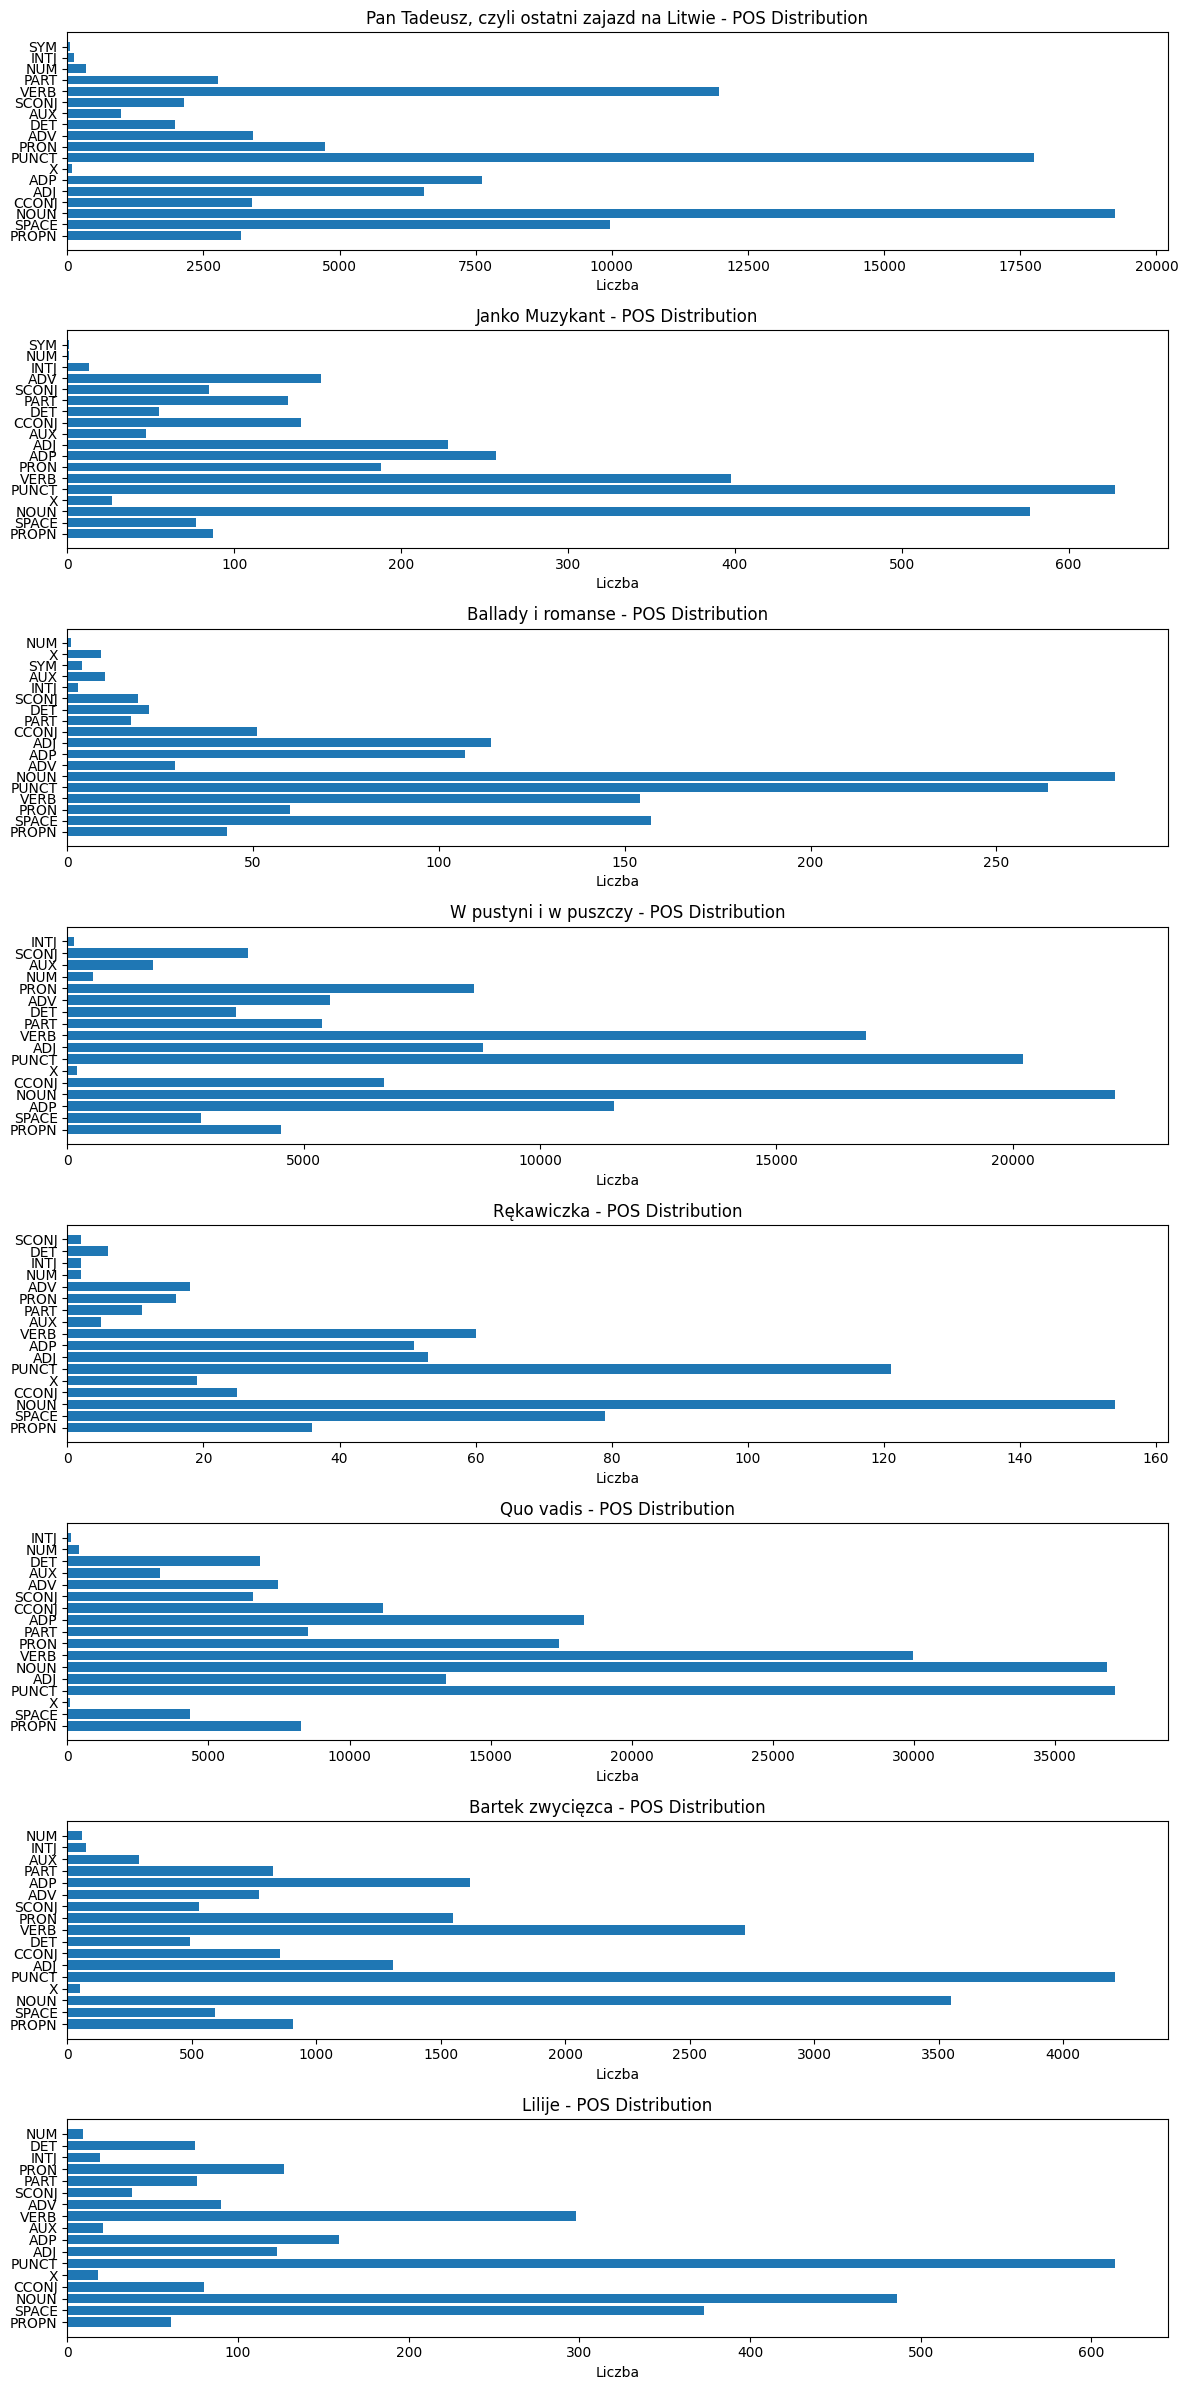

In [14]:
fig, axes = plt.subplots(len(pos_results), 1, figsize=(12, 3 * len(pos_results)))
if len(pos_results) == 1:
  axes = [axes]

for idx, result in enumerate(pos_results):
  pos_dict = result['pos_counts']
  tags = list(pos_dict.keys())
  counts = list(pos_dict.values())

  axes[idx].barh(tags, counts)
  axes[idx].set_title(f'{result["title"]} - POS Distribution')
  axes[idx].set_xlabel('Liczba')

plt.tight_layout()
plt.show()

# Punkt 2b - Częstość tagów morfologicznych (części mowy szczegółowe)

In [15]:
morph_results = []

for book in corpus:
  print(f"Przetwarzanie: {book['title']}")
  doc = nlp(book['text'])

  morph_tags = [token.tag_ for token in doc if token.tag_ != '']
  morph_counter = Counter(morph_tags)

  morph_results.append({
      'title': book['title'],
      'morph_counts': morph_counter,
      'total_tokens': len(doc)
  })

  print(f"done ({len(doc)} tokenow)")


Przetwarzanie: Pan Tadeusz, czyli ostatni zajazd na Litwie
done (96269 tokenow)
Przetwarzanie: Janko Muzykant
done (3093 tokenow)
Przetwarzanie: Ballady i romanse
done (1346 tokenow)
Przetwarzanie: W pustyni i w puszczy
done (123348 tokenow)
Przetwarzanie: Rękawiczka
done (660 tokenow)
Przetwarzanie: Quo vadis
done (210263 tokenow)
Przetwarzanie: Bartek zwycięzca
done (20399 tokenow)
Przetwarzanie: Lilije
done (2667 tokenow)


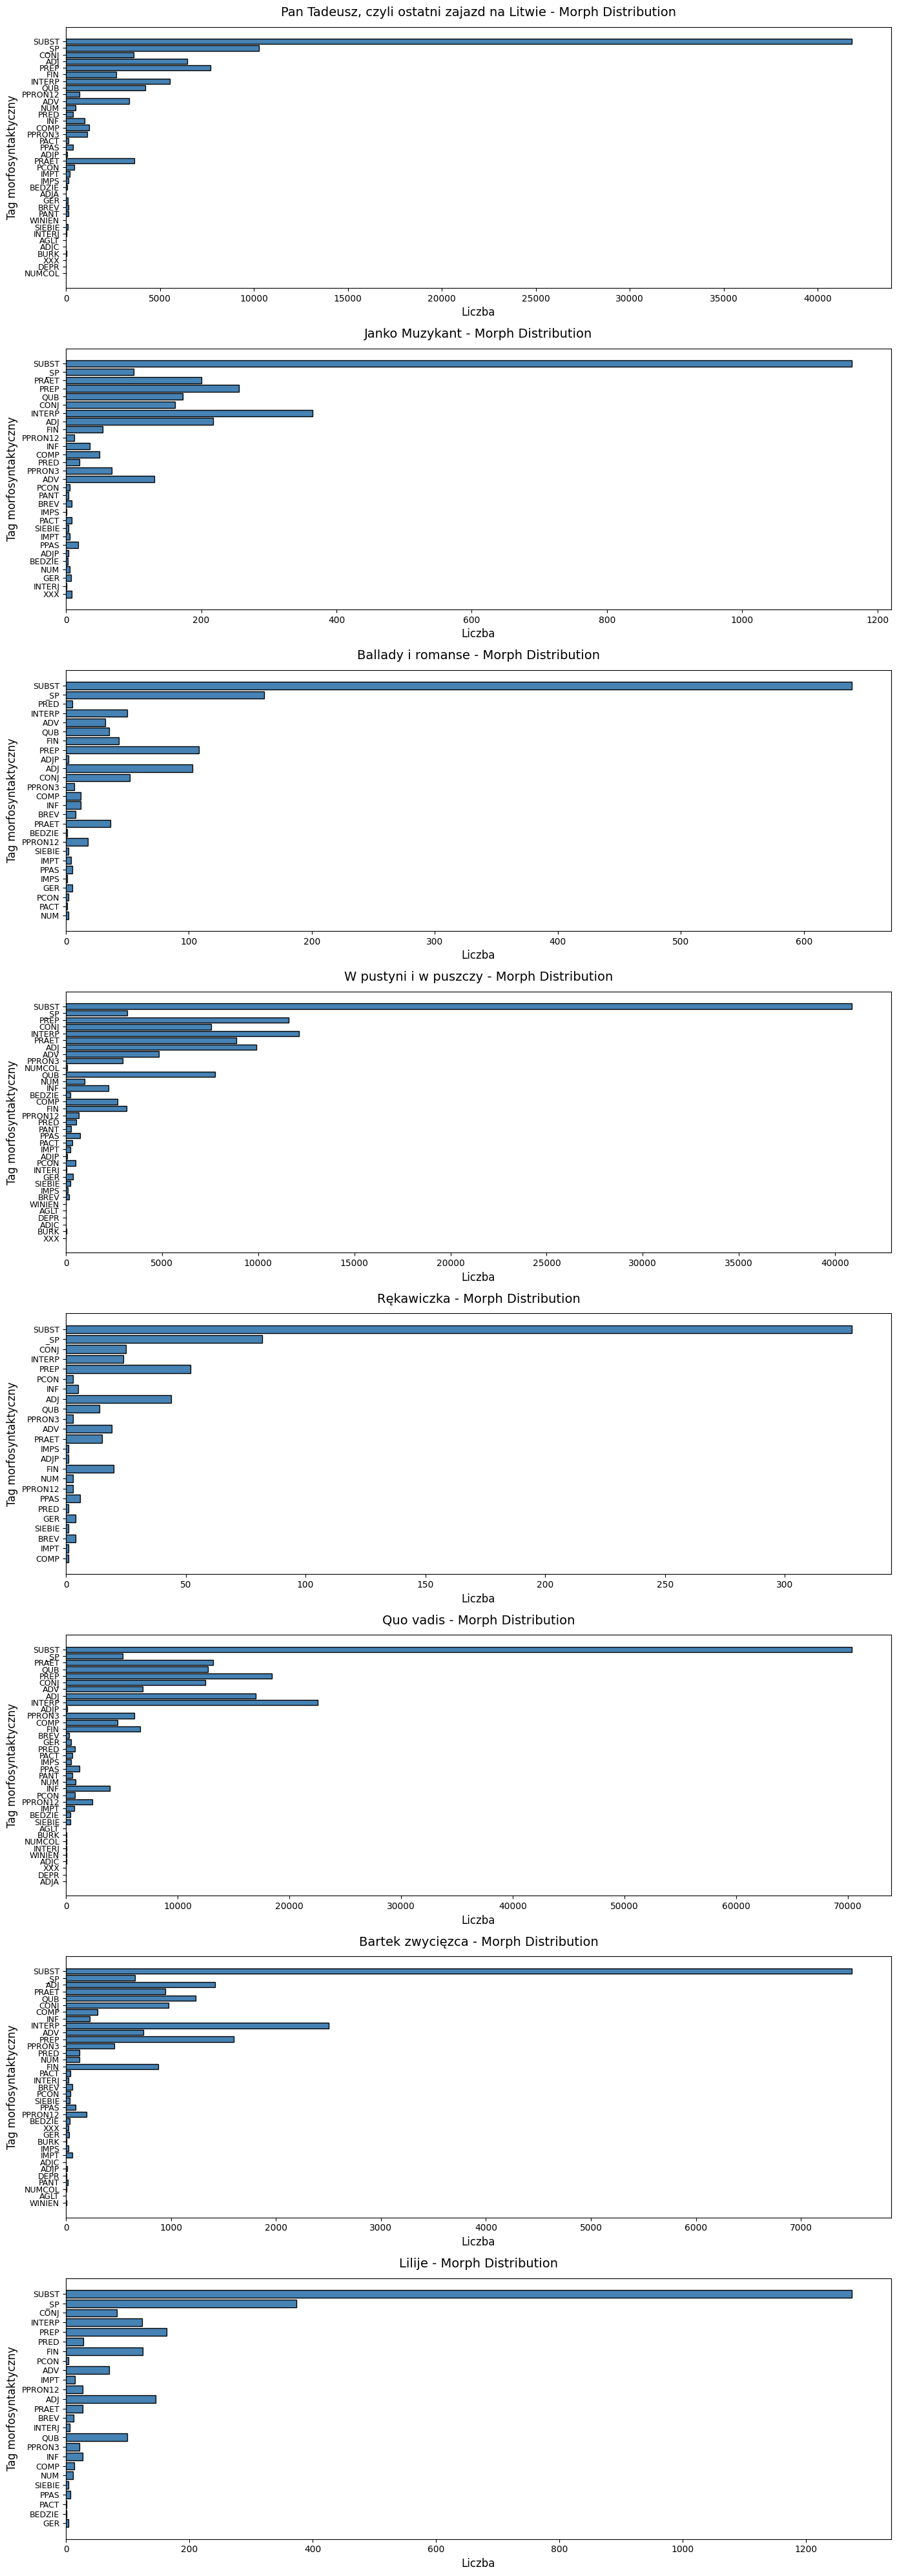

In [16]:
fig, axes = plt.subplots(len(morph_results), 1, figsize=(14, 5 * len(morph_results)))

if len(morph_results) == 1:
    axes = [axes]

for idx, result in enumerate(morph_results):
    morph_dict = result['morph_counts']
    tags = list(morph_dict.keys())
    counts = list(morph_dict.values())

    axes[idx].barh(tags, counts, color='steelblue', edgecolor='black')
    axes[idx].set_title(f'{result["title"]} - Morph Distribution', fontsize=14, pad=12)
    axes[idx].set_xlabel('Liczba', fontsize=12)
    axes[idx].set_ylabel('Tag morfosyntaktyczny', fontsize=12)

    axes[idx].invert_yaxis()

    axes[idx].tick_params(axis='y', labelsize=9)
    axes[idx].tick_params(axis='x', labelsize=10)
    plt.tight_layout()

plt.show()


# 3. Na podstawie korpusu zbudowanego   z 5 dowolnych książek ściągniętych ze strony Wolne Lektury wyznaczyć i zwizualizować częstość występowania rzeczowników sprowadzonych do form podstawowych.

In [18]:
import matplotlib.pyplot as plt
from collections import Counter

selected_corpus = corpus[:5]
noun_results = []
for book in selected_corpus:
  print(f"Przetwarzanie: {book['title']}")
  doc = nlp(book['text'])

  nouns = [token.lemma_ for token in doc if token.pos_ == 'NOUN']
  noun_counter = Counter(nouns)

  noun_results.append({
      'title': book['title'],
      'noun_counts': noun_counter,
      'total_tokens': len(nouns),
      'unique_nouns': len(noun_counter)
  })

  print(f"✓ {len(nouns)} rzeczowników, {len(noun_counter)} unikalnych")

Przetwarzanie: Pan Tadeusz, czyli ostatni zajazd na Litwie
✓ 19244 rzeczowników, 6119 unikalnych
Przetwarzanie: Janko Muzykant
✓ 577 rzeczowników, 356 unikalnych
Przetwarzanie: Ballady i romanse
✓ 282 rzeczowników, 221 unikalnych
Przetwarzanie: W pustyni i w puszczy
✓ 22173 rzeczowników, 4622 unikalnych
Przetwarzanie: Rękawiczka
✓ 154 rzeczowników, 117 unikalnych


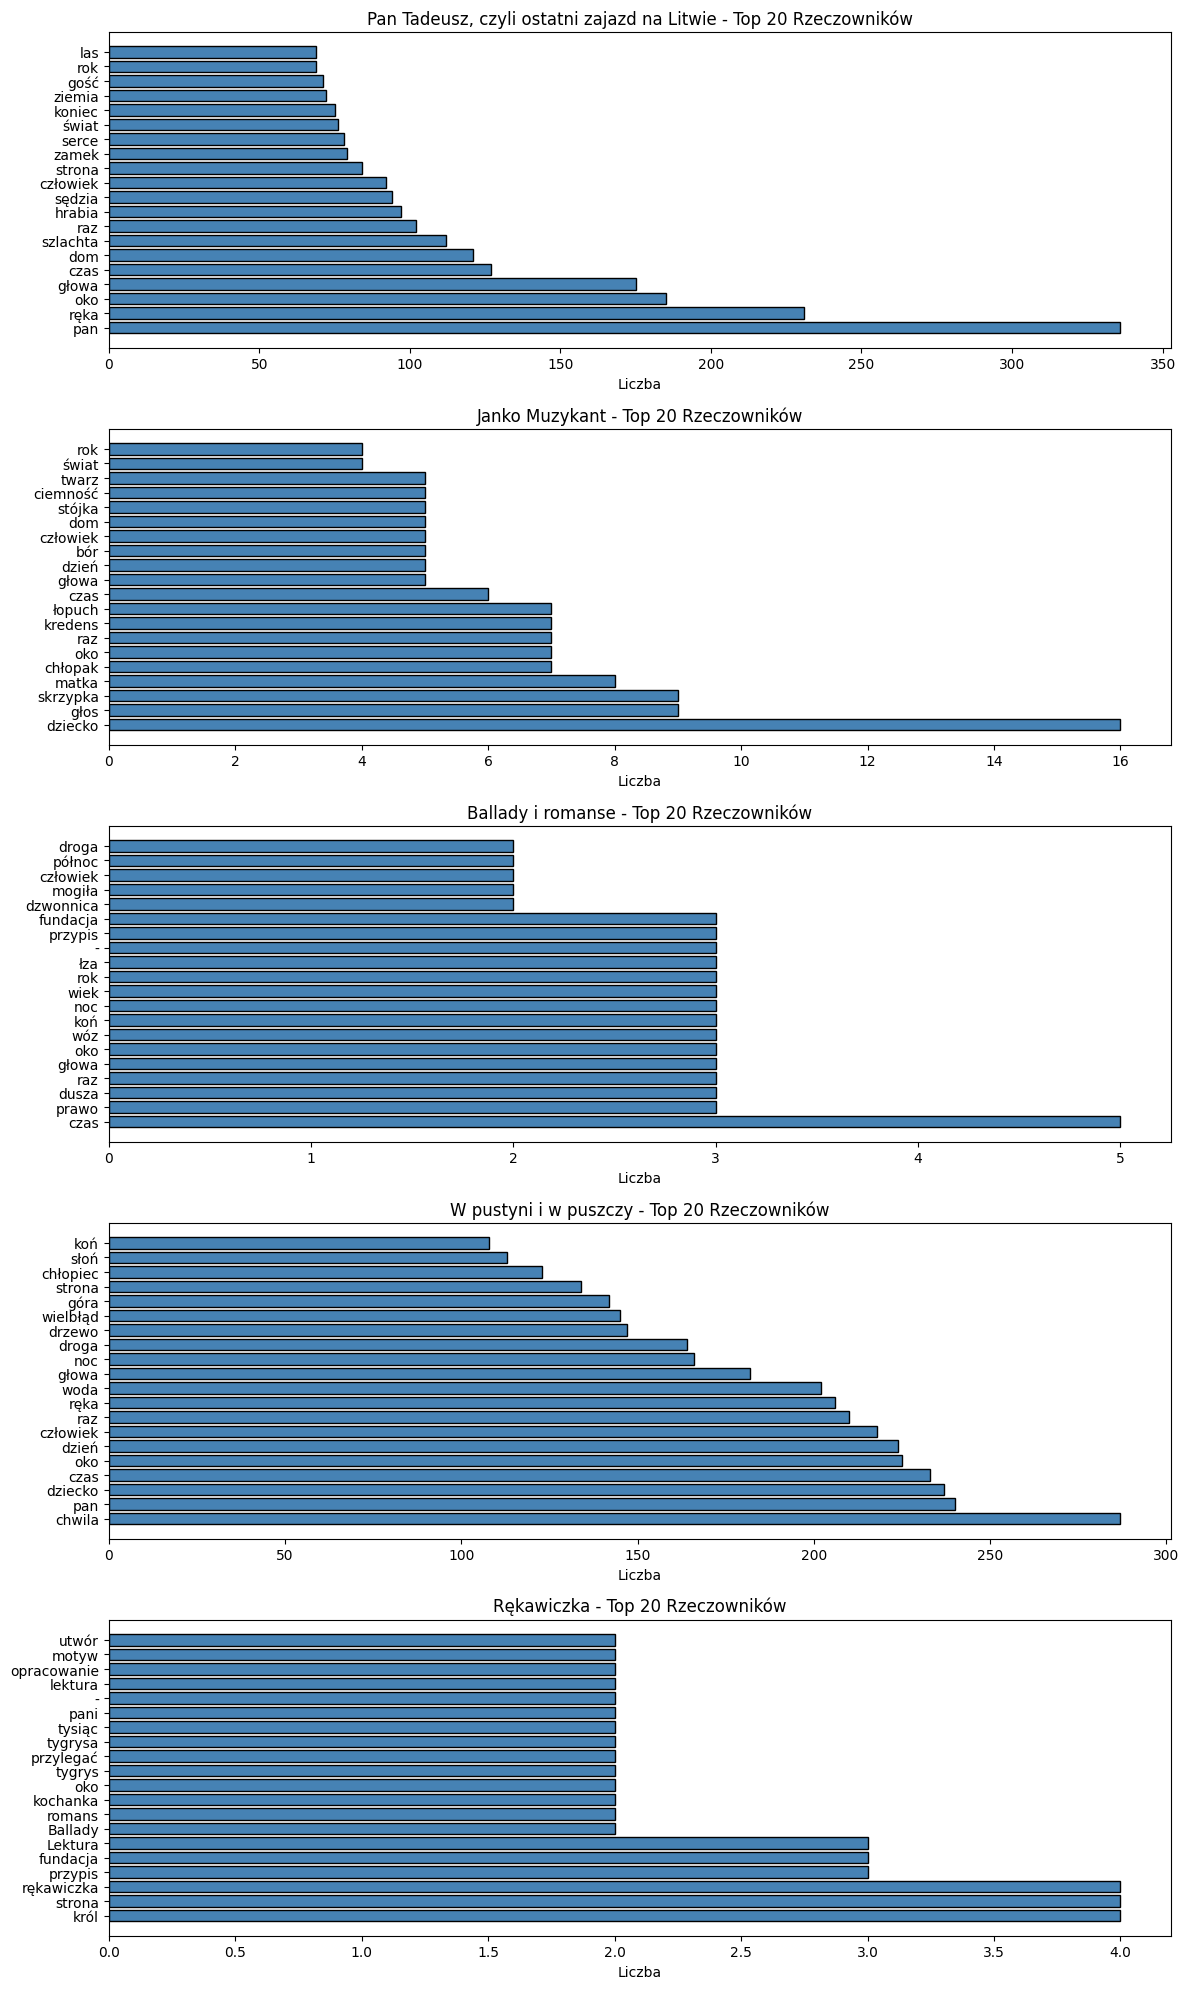

In [23]:
fig, axes = plt.subplots(len(noun_results), 1, figsize=(12, 4 * len(noun_results)))
if len(noun_results) == 1:
    axes = [axes]

for idx, result in enumerate(noun_results):
    noun_dict = result['noun_counts']
    top_20 = dict(sorted(noun_dict.items(), key=lambda x: x[1], reverse=True)[:20])

    nouns = list(top_20.keys())
    counts = list(top_20.values())

    axes[idx].barh(nouns, counts, color='steelblue', edgecolor='black')
    axes[idx].set_title(f'{result["title"]} - Top 20 Rzeczowników')
    axes[idx].set_xlabel('Liczba')

plt.tight_layout()
plt.show()

# 4. TF-IDF na rzeczownikach + Wordcloud



In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

noun_texts = []
for book in selected_corpus:
  print(f"Przetwarzanie: {book['title']}")
  doc = nlp(book['text'])
  nouns = [token.lemma_ for token in doc if token.pos_ == 'NOUN']
  noun_texts.append(' '.join(nouns))

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(noun_texts)
print(f"TF-IDF macierz: {tfidf_matrix.shape}")
print(f"dokumenty: {tfidf_matrix.shape[0]}, features: {tfidf_matrix.shape[1]}\n")



Przetwarzanie: Pan Tadeusz, czyli ostatni zajazd na Litwie
Przetwarzanie: Janko Muzykant
Przetwarzanie: Ballady i romanse
Przetwarzanie: W pustyni i w puszczy
Przetwarzanie: Rękawiczka
TF-IDF macierz: (5, 9106)
dokumenty: 5, features: 9106



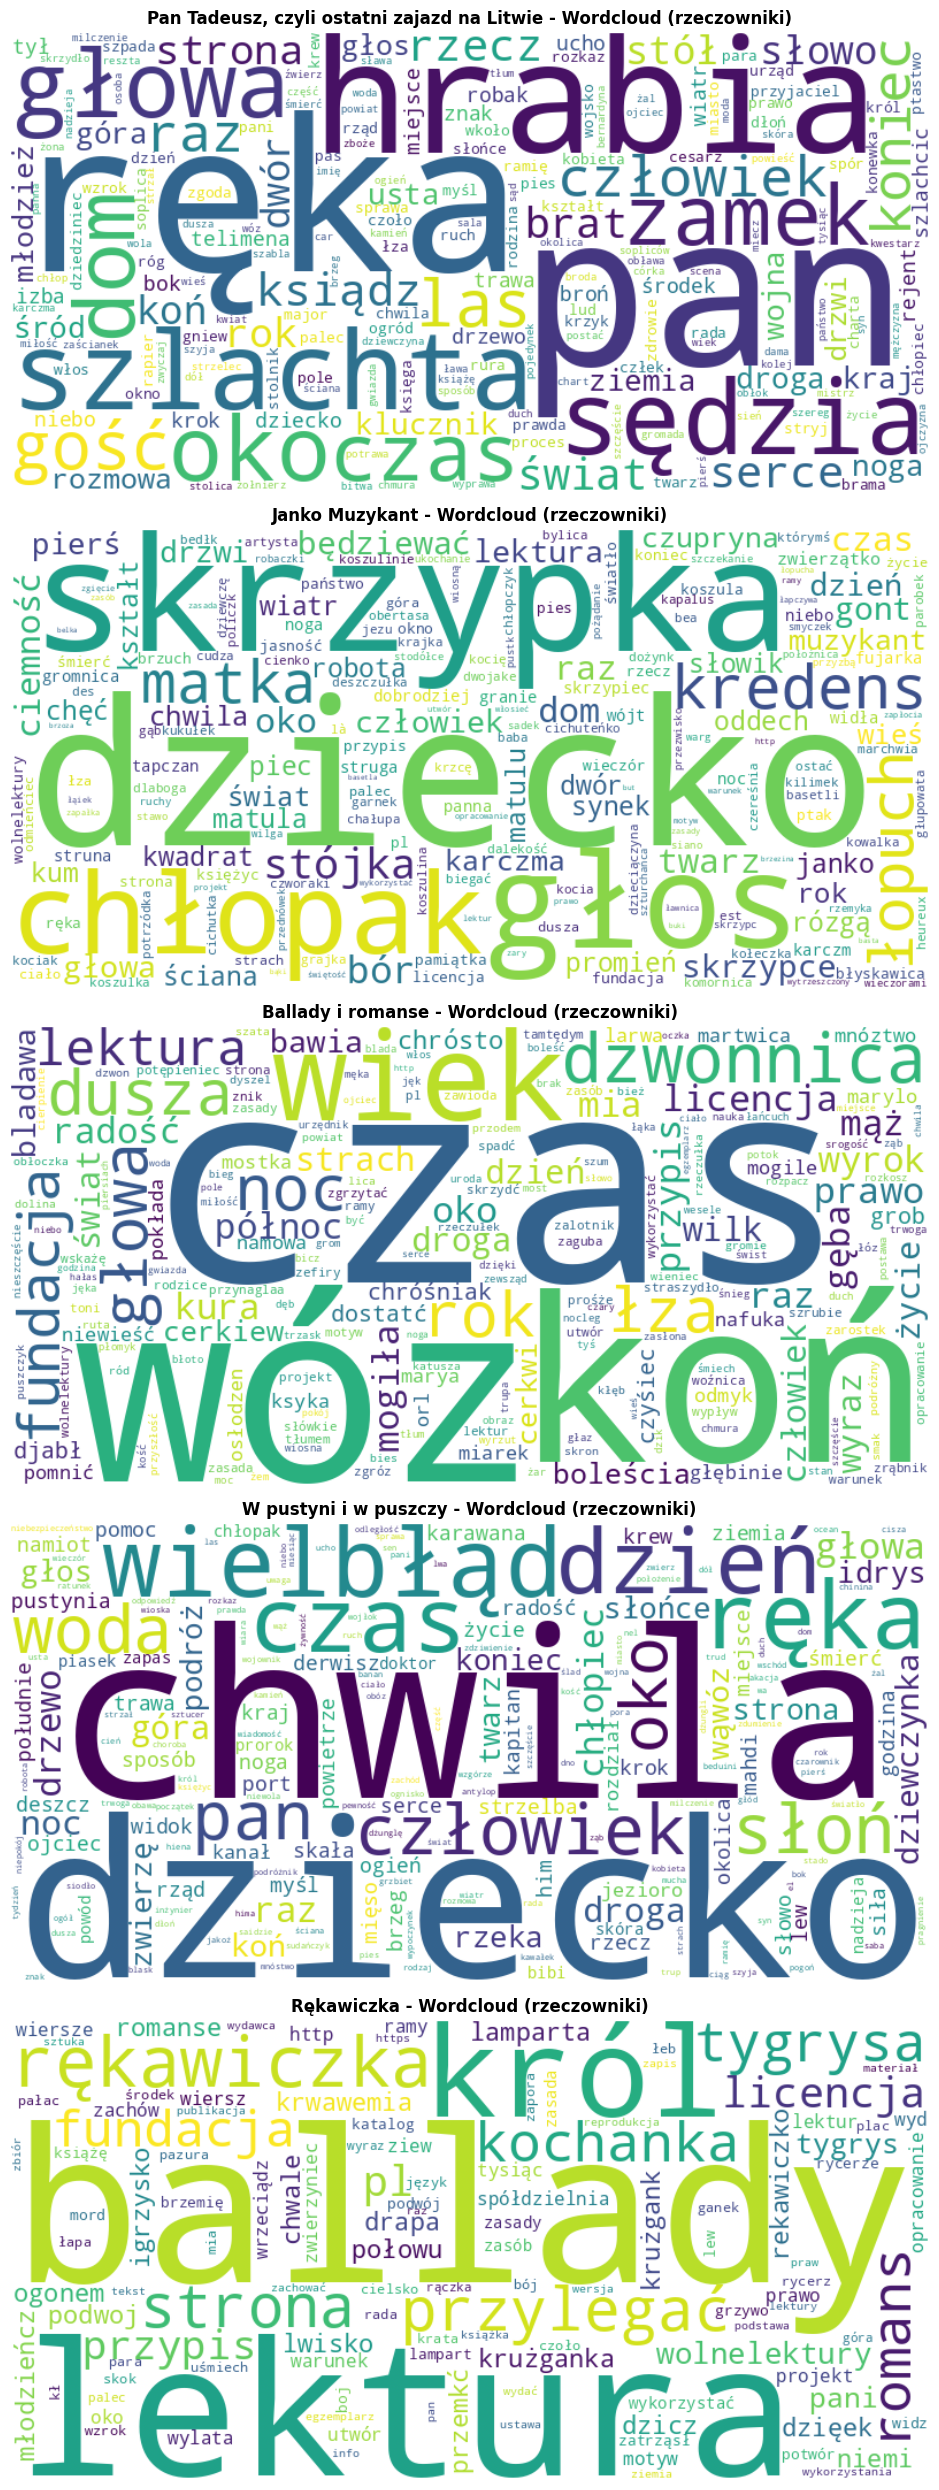

In [26]:
fig, axes = plt.subplots(len(selected_corpus), 1, figsize=(14, 5 * len(selected_corpus)))
if len(selected_corpus) == 1:
    axes = [axes]

for idx, book in enumerate(selected_corpus):
    tfidf_scores = tfidf_matrix[idx].toarray()[0]
    feature_names = tfidf.get_feature_names_out()

    # slowo -> wartosc z tfidfa, jakos parametr wielkosci dla cloud
    word_freq = dict(zip(feature_names, tfidf_scores))
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white'
        ).generate_from_frequencies(word_freq)


    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{book["title"]} - Wordcloud (rzeczowniki)', fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# 5. Podać kilka przykładów  niejednoznaczności znaczeniowej  występującej w tekstach oraz przyjęty sposób ich rozwiązania

### Przykłady znalezione w korpusie:

**1. Polisemia (jedno słowo, wiele znaczeń):**
- "bank" - instytucja finansowa vs. brzeg rzeki
- "mysz" - zwierzę vs. urządzenie komputerowe
- "pióro" - ptasia pióra vs. przyrząd do pisania

**2. Homonimy (identyczna forma, różne znaczenia):**
- "leć" (czasownik: lecieć) vs. "leć" (imię)

**3. Odwołania anafora (ten, która, coś):**
- "Piotr spotkał Janka. Powiedział mu, że..." - kto powiedział? Piotr czy Janek?

### Sposób rozwiązania przez spaCy:

1. **POS Tagging** - określenie części mowy (czasownik, rzeczownik)
   - Odróżnia "mysz" (NOUN) od "mysz" jako czasownika (jeśli by istniał)

2. **Lemmatyzacja** - sprowadzenie do formy podstawowej
   - "wróć", "wróciłem", "wrócisz" → wszystko "wrócić"

3. **Dependency Parsing** - analiza składniowa
   - Zidentyfikowanie subiektu i obiektu w zdaniu

4. **Kontekst syntaktyczny** - sąsiednie tokeny
   - Słowa w pobliżości pomagają określić znaczenie

# 6. W wybranej lekturze znaleźć 5  rzeczowników występujących w formie podmiotów oraz pokazać z jakimi czasownikami się łączą  w związku podmiotu z orzeczeniem.

> Alternatywnie zamiast szukania pochodnych czasownika w postaci nominalnej ktora jest rzeczownikiem mozna by zrobic to na odwrót, czyli wyjsc z rzeczownika i szykac root ktory bylby VERB oraz nsubj.

```python
for token in doc:
    if token.pos_ == 'NOUN':
        for head in [token.head]:
            if head.pos_ == 'VERB' and token.dep_ == 'nsubj':
```



In [38]:
import spacy
from collections import defaultdict

show_values = 5
selected_book = corpus[0]
doc = nlp(selected_book['text'])

subject_verb_pairs = defaultdict(list)

for token in doc:
    if token.pos_ == 'VERB':
        for child in token.children:
            # nsubj = nominal subject + filtr na rzeczowniki
            # jak dawalem sam nsubj to mialem polowe tych slow jako zaimki
            if child.dep_ == 'nsubj' and child.pos_ == 'NOUN':
                subject_noun = child.lemma_
                verb = token.lemma_
                subject_verb_pairs[subject_noun].append(verb)

top_subjects = sorted(subject_verb_pairs.items(),
                      key=lambda x: len(x[1]),
                      reverse=True)[:show_values]

print(f"5 rzeczownikow najczesc. wystepujacych w ksiazce: '{selected_book['title']}' \n")

for rank, (subject, verbs) in enumerate(top_subjects, 1):
    verb_counter = defaultdict(int)
    for verb in verbs:
        verb_counter[verb] += 1

    sorted_verbs = sorted(verb_counter.items(), key=lambda x: x[1], reverse=True)

    print(f"{rank}. Rzeczownik '{subject}' ({len(verbs)} razy):")
    for verb, count in sorted_verbs[:show_values]:
        print(f"   - {verb} ({count}x)")
    print()


5 rzeczownikow najczesc. wystepujacych w ksiazce: 'Pan Tadeusz, czyli ostatni zajazd na Litwie' 

1. Rzeczownik 'pan' (132 razy):
   - wiedzieć (5x)
   - stać (4x)
   - rzec (4x)
   - móc (3x)
   - mieć (2x)

2. Rzeczownik 'sędzia' (64 razy):
   - rzec (7x)
   - krzyknąć (3x)
   - chcieć (2x)
   - słuchać (2x)
   - zapytać (2x)

3. Rzeczownik 'hrabia' (59 razy):
   - rzec (6x)
   - lubić (2x)
   - stać (2x)
   - mieć (2x)
   - siedzieć (2x)

4. Rzeczownik 'oko' (32 razy):
   - obracać (2x)
   - podnieść (1x)
   - tuczyć (1x)
   - zobaczyć (1x)
   - zmrużyć (1x)

5. Rzeczownik 'ksiądz' (32 razy):
   - rzec (3x)
   - gadać (2x)
   - chodzić (1x)
   - dyszać (1x)
   - przemycać (1x)



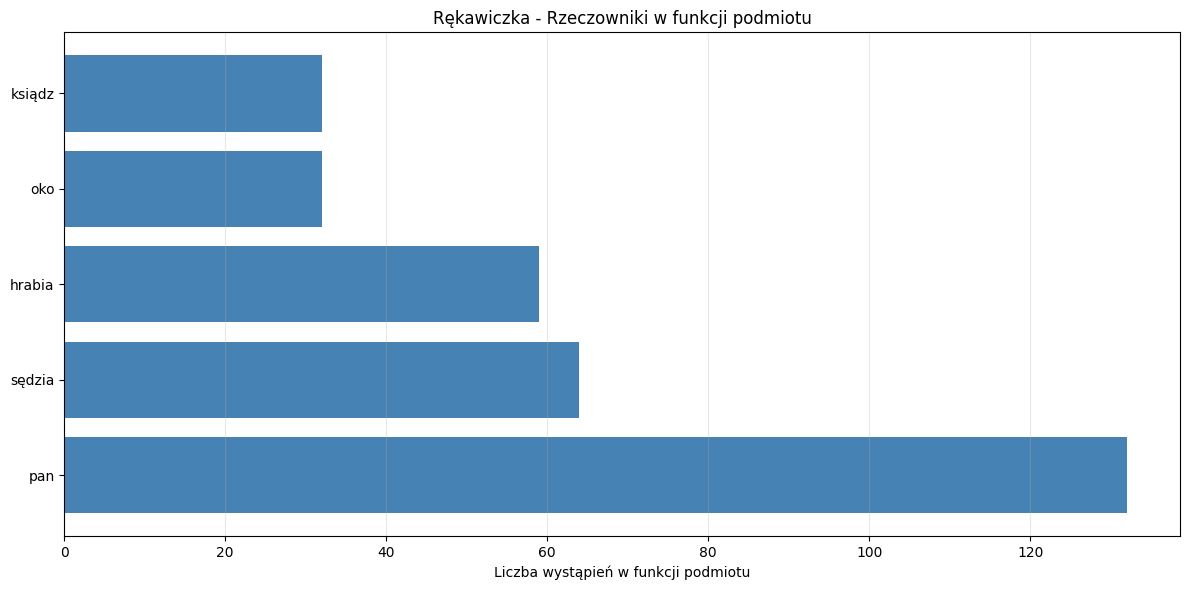

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))

subjects = [s[0] for s in top_subjects]
counts = [len(s[1]) for s in top_subjects]

ax.barh(subjects, counts, color='steelblue')
ax.set_xlabel('Liczba wystąpień w funkcji podmiotu')
ax.set_title(f'{book["title"]} - Rzeczowniki w funkcji podmiotu')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()